# Collaborative Filtering and Hybrid Filtering

Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import time
import scipy
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, cdist, jaccard

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Load data

In [2]:
dtrain = pd.read_csv('Data/dtrain_cleaned.csv')
dtest = pd.read_csv('Data/dtest_cleaned.csv')

In [3]:
dtrain.describe()

,Unnamed: 0,AktorId,Alder,FylkeNr,KommuneNr,Postnr,ErDisponentAnt,ErKontoapnerAnt,ErKausjonistAnt,ErRealkausjonistAnt,...,AntSparekonto,AntAktiveSkadefors,AntAktiv_AndreForsikringer,AntAktUtlanAvt,AntAvtBSU,AntAktBoliglan,DNBAntAktBoliglan,AntAktGaranterte,AntAktLink,AntAktSpareforsikring
count,3630.000000,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,2508.213774,3.218082e+06,43.208815,7.695868,783.614325,3613.719008,0.300551,0.055923,0.000551,0.014601,...,0.701653,0.102479,0.102204,0.178512,0.107713,0.176584,0.045455,0.044077,0.011846,0.201377
std,1431.680916,2.104151e+06,14.468157,5.738833,576.161533,2556.014909,0.458561,0.229804,0.023469,0.119964,...,0.457596,0.303319,0.302958,0.382996,0.310061,0.381369,0.208328,0.205295,0.108206,0.401085
min,0.000000,9.380000e+02,18.000000,1.000000,101.000000,168.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1284.500000,1.548604e+06,31.000000,3.000000,301.000000,1453.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2512.500000,2.712668e+06,43.000000,6.000000,621.500000,3124.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3731.500000,4.479664e+06,55.000000,12.000000,1201.000000,5229.750000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4998.000000,9.424479e+06,70.000000,20.000000,2030.000000,9990.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Remove unnamed

In [4]:
dtrain = dtrain.drop('Unnamed: 0',1)
dtest = dtest.drop('Unnamed: 0',1)

Define ID and target variables

In [5]:
ID_col = 'AktorId'
target_cols = ['AntAktAvtBank',
 'AntAktAvtInnskudd',
 'AntAktAvtKredittkort',
 'AntKredittkortDebet',
 'AntKredittkortKreditt',
 'AntSparekonto',
 'AntBrukskonto',
 'AntAvtBSU',
 'AntAktiveSkadefors',
 'AntAktiv_AndreForsikringer',
 'AntAktSpareforsikring',
 'AntAktUtlanAvt',
 'AntAktBoliglan',
 'DNBAntAktBoliglan',
 'AntAktGaranterte',
 'AntAktLink']

Create train and test set with product variables

In [6]:
dtrain_id = dtrain['AktorId']
dtest_id = dtest['AktorId']
dtrain_matrix = dtrain[[col for col in target_cols]]
dtest_matrix = dtest[[col for col in target_cols]]

## 1. User Based Collaborative filtering (with KNN)

Calculate Jaccard similarity for train set

In [7]:
def similarity_train(dtrain_matrix):
    t0 = time.time()
    n_users=len(dtrain_matrix)
    n_items=len(target_cols)
    similarity_train=np.zeros((n_items,n_users,n_users))
    i=0
    for col in dtrain_matrix.columns:
        cols = [x for x in dtrain_matrix.columns if x not in col]
        similarity_train[i,:,:] = squareform(1-pdist(dtrain_matrix[cols],'jaccard'))
        i+=1
    t1 = time.time()
    time_sim_train = t1-t0
    print('Similarity time train %.4g' % time_sim_train)
    return time_sim_train,similarity_train

In [8]:
time_sim_train,similarity_train = similarity_train(dtrain_matrix)

Similarity time train 13.4


Prediction function selecting the neighbors from the similarity measure

In [9]:
def prediction(target,sim,n_nbrs):
    t0 = time.time()
    n_nbrs = n_nbrs
    n_users=len(sim[0])
    n_items=len(target.columns)
    pred=np.zeros((n_users,n_items))
    for i in range (n_items):
        for u in range (n_users):
            nbrs_indices = [j[0] for j in sorted(enumerate(sim[i,u,:]),key=lambda x:x[1],reverse=True)[:n_nbrs]]
            vote_1=0
            vote_2=0
            for n in nbrs_indices: 
                vote_1 += target.values[n,i]*sim[i,u,n]
                vote_2 += (1-target.values[n,i])*sim[i,u,n]
            if(vote_1>vote_2):
                pred[u,i]=1
    t1 = time.time()
    time_pred = t1-t0
    print('Prediction time %.4g' % time_pred)
    return time_pred,n_nbrs, pred

Function for calculating the prediction accuracy

In [10]:
def accuracy(target,pred,n_nbrs,reports=False):
    print('\nModel Report: k =',n_nbrs,'\n')
    i=0
    accuracy_lst=[]
    for col in target.columns:
        accuracy = metrics.accuracy_score(target.values[:,i],pred[:,i])
        accuracy_lst.append(accuracy)
        print (col, '%.4g' % accuracy)
        if(reports==True):
            report = classification_report(target.values[:,i],pred[:,i])
            print(report)
            cm = confusion_matrix(target.values[:,i],pred[:,i])
            print(cm)
        i+=1
    avg_accuracy = np.average(accuracy_lst)
    print('\nAverage accuracy %.4g' % avg_accuracy)
    return accuracy_lst, avg_accuracy

Parameter tuning: tune the number of neighbors

In [11]:
k_accuracy=[]
k_time=[]
tot_nbrs = 25
for i in range (5,tot_nbrs+1):
    time_pred_train,n_nbrs,pred_train = prediction(dtrain_matrix,similarity_train,i)
    accuracy_train,avg_accuracy_train = accuracy(dtrain_matrix,pred_train,n_nbrs)
    k_accuracy.append(avg_accuracy_train)
    k_time.append(time_pred_train)

Prediction time 256.5

Model Report: k = 5 

AntAktAvtBank 0.9485
AntAktAvtInnskudd 0.981
AntAktAvtKredittkort 0.719
AntKredittkortDebet 0.765
AntKredittkortKreditt 0.9523
AntSparekonto 0.7482
AntBrukskonto 0.8364
AntAvtBSU 0.8879
AntAktiveSkadefors 0.9964
AntAktiv_AndreForsikringer 0.9964
AntAktSpareforsikring 0.8361
AntAktUtlanAvt 0.9975
AntAktBoliglan 0.9978
DNBAntAktBoliglan 0.9493
AntAktGaranterte 0.9499
AntAktLink 0.9882

Average accuracy 0.9094
Prediction time 257.6

Model Report: k = 6 

AntAktAvtBank 0.949
AntAktAvtInnskudd 0.981
AntAktAvtKredittkort 0.7237
AntKredittkortDebet 0.7708
AntKredittkortKreditt 0.9573
AntSparekonto 0.7347
AntBrukskonto 0.8377
AntAvtBSU 0.8882
AntAktiveSkadefors 0.9978
AntAktiv_AndreForsikringer 0.9978
AntAktSpareforsikring 0.8474
AntAktUtlanAvt 0.9975
AntAktBoliglan 0.9978
DNBAntAktBoliglan 0.9537
AntAktGaranterte 0.9485
AntAktLink 0.9879

Average accuracy 0.9107
Prediction time 253.9

Model Report: k = 7 

AntAktAvtBank 0.9477
AntAktAvtInnskudd 0.9

Plot the accuracy for different K values

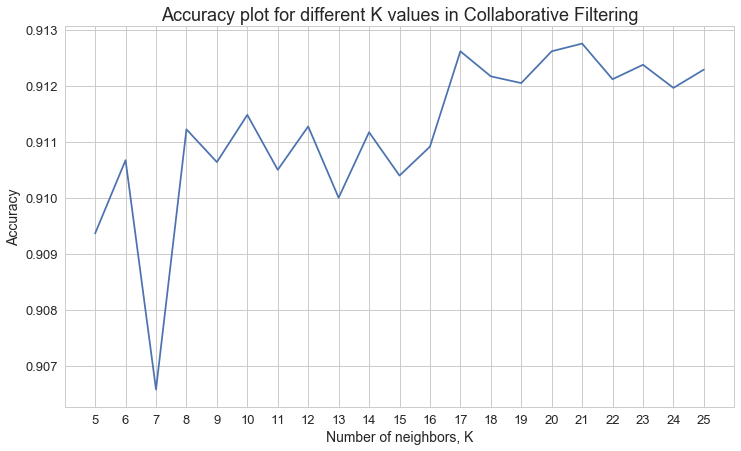

In [12]:
k_indices=np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
k_indices.astype(int)
    
with sns.plotting_context("notebook",font_scale=1.3):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_accuracy);
    plt.xticks(k_indices, k_indices)
    plt.title('Accuracy plot for different K values in Collaborative Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=14)
    plt.ylabel('Accuracy',fontsize=14)
    plt.savefig('collaborative_acc')
    plt.show()
    plt.close()

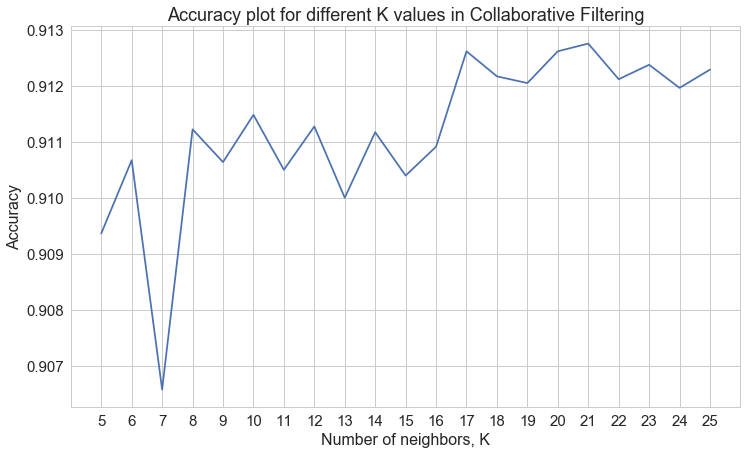

In [37]:
k_indices=np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
k_indices.astype(int)
    
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_accuracy);
    plt.xticks(k_indices, k_indices)
    plt.title('Accuracy plot for different K values in Collaborative Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.savefig('collaborative_acc_2')
    plt.show()
    plt.close()

Plot the running time for different K values

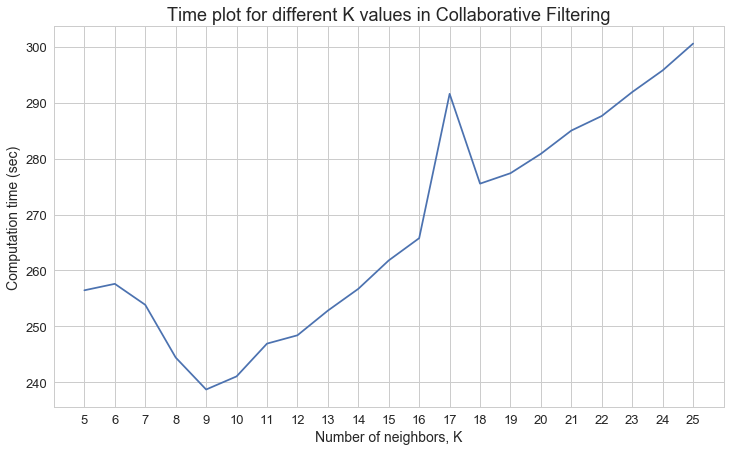

In [13]:
k_indices=np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
k_indices.astype(int)
    
with sns.plotting_context("notebook",font_scale=1.3):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_time);
    plt.xticks(k_indices, k_indices)
    plt.title('Time plot for different K values in Collaborative Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=14)
    plt.ylabel('Computation time (sec)',fontsize=14)
    plt.savefig('collaborative_time')
    plt.show()
    plt.close()

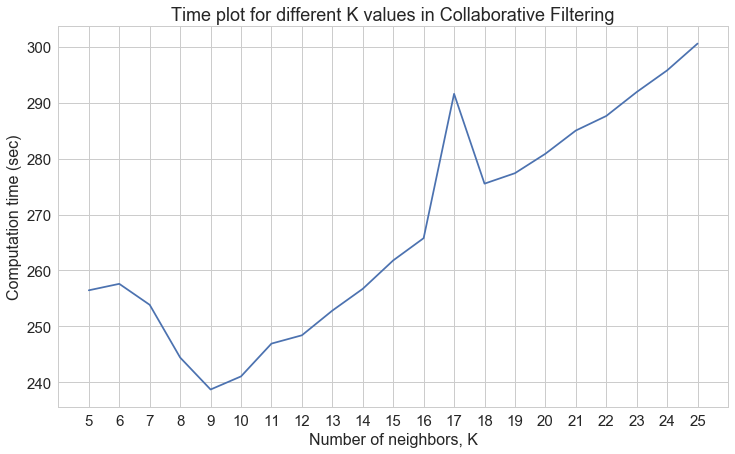

In [36]:
k_indices=np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
k_indices.astype(int)
    
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_time);
    plt.xticks(k_indices, k_indices)
    plt.title('Time plot for different K values in Collaborative Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=16)
    plt.ylabel('Computation time (sec)',fontsize=16)
    plt.savefig('collaborative_time_2')
    plt.show()
    plt.close()

Predict items for train set with optimal K value

In [14]:
opt_n_nbrs = k_accuracy.index(max(k_accuracy))+5
time_pred_train,opt_n_nbrs,pred_train = prediction(dtrain_matrix,similarity_train,opt_n_nbrs)

Prediction time 285.9


Calculate the accuracy for the train set

In [15]:
accuracy_train,avg_accuracy_train = accuracy(dtrain_matrix,pred_train,opt_n_nbrs,reports=True)


Model Report: k = 21 

AntAktAvtBank 0.9477
             precision    recall  f1-score   support

          0       0.87      0.59      0.70       383
          1       0.95      0.99      0.97      3247

avg / total       0.94      0.95      0.94      3630

[[ 227  156]
 [  34 3213]]
AntAktAvtInnskudd 0.9785
             precision    recall  f1-score   support

          0       0.89      0.82      0.85       277
          1       0.99      0.99      0.99      3353

avg / total       0.98      0.98      0.98      3630

[[ 227   50]
 [  28 3325]]
AntAktAvtKredittkort 0.735
             precision    recall  f1-score   support

          0       0.61      0.91      0.73      1434
          1       0.91      0.62      0.74      2196

avg / total       0.79      0.73      0.74      3630

[[1303  131]
 [ 831 1365]]
AntKredittkortDebet 0.7545
             precision    recall  f1-score   support

          0       0.87      0.79      0.83      2726
          1       0.51      0.64      0.57 

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.89      1.00      0.94      3239
          1       0.00      0.00      0.00       391

avg / total       0.80      0.89      0.84      3630

[[3239    0]
 [ 391    0]]
AntAktiveSkadefors 0.9964
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3258
          1       1.00      0.97      0.98       372

avg / total       1.00      1.00      1.00      3630

[[3258    0]
 [  13  359]]
AntAktiv_AndreForsikringer 0.9964
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3259
          1       1.00      0.97      0.98       371

avg / total       1.00      1.00      1.00      3630

[[3258    1]
 [  12  359]]
AntAktSpareforsikring 0.8388
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      2899
          1       1.00      0.20      0.33       731

avg / total       0.87  

Calculate Jaccard similarity between each user in test set and every user in train set

In [16]:
def similarity_test(dtrain_matrix,dtest_matrix):
    t0 = time.time()
    n_users_test=len(dtest_matrix)
    n_users_train=len(dtrain_matrix)
    n_items=len(dtrain_matrix.columns)
    similarity_test=np.zeros((n_items,n_users_test,n_users_train))
    i=0
    for col in dtest_matrix.columns:
        cols = [x for x in dtest_matrix.columns if x not in col]
        similarity_test[i,:,:]  = (1-cdist(dtest_matrix[cols],dtrain_matrix[cols],'jaccard'))
        i+=1
    t1 = time.time()
    time_sim_test = t1-t0
    print('Similarity time test %.4g' % time_sim_test)
    return time_sim_test,similarity_test

In [17]:
time_sim_test,similarity_test = similarity_test(dtrain_matrix,dtest_matrix)

Similarity time test 5.175


Predict items for test set

In [18]:
time_pred_test,opt_n_nbrs,pred_test = prediction(dtrain_matrix,similarity_test,opt_n_nbrs)

Prediction time 95.71


Calculate the accuracy for the test set

In [19]:
accuracy_test,avg_accuracy_test = accuracy(dtest_matrix,pred_test,opt_n_nbrs,reports=True)


Model Report: k = 21 

AntAktAvtBank 0.9455
             precision    recall  f1-score   support

          0       0.87      0.56      0.68       126
          1       0.95      0.99      0.97      1084

avg / total       0.94      0.95      0.94      1210

[[  71   55]
 [  11 1073]]
AntAktAvtInnskudd 0.976
             precision    recall  f1-score   support

          0       0.82      0.85      0.83        85
          1       0.99      0.99      0.99      1125

avg / total       0.98      0.98      0.98      1210

[[  72   13]
 [  16 1109]]
AntAktAvtKredittkort 0.7058
             precision    recall  f1-score   support

          0       0.58      0.91      0.71       476
          1       0.91      0.57      0.70       734

avg / total       0.78      0.71      0.71      1210

[[432  44]
 [312 422]]
AntKredittkortDebet 0.7736
             precision    recall  f1-score   support

          0       0.89      0.81      0.85       937
          1       0.50      0.65      0.56     

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2. Hybrid Filtering with Feature Combination

Get demographic and collaborative similarity matrices

In [20]:
def get_demo_sim():
    demo_sim_train = pd.read_csv('Results/Demographic_similarity_train.csv')
    demo_sim_train = np.array(demo_sim_train)
    demo_sim_test = pd.read_csv('Results/Demographic_similarity_test.csv')
    demo_sim_test = np.array(demo_sim_test)
    return demo_sim_train,demo_sim_test

In [21]:
demo_sim_train,demo_sim_test = get_demo_sim()

In [22]:
col_sim_train = similarity_train
col_sim_test = similarity_test

Hybrid prediction function with feature combination

In [23]:
def feature_hybrid_prediction(target,demo_sim,col_sim,n_nbrs_demo,n_nbrs_col):
    t0 = time.time()
    n_nbrs_demo = n_nbrs_demo
    n_nbrs_col = n_nbrs_col
    n_users=len(demo_sim)
    n_items=len(target.columns)
    pred=np.zeros((n_users,n_items))

    for u in range (n_users):
        nbrs_indices_demo = [j[0] for j in sorted(enumerate(demo_sim[u,:]),
                                                  key=lambda x:x[1],reverse=True)[:n_nbrs_demo]]
        for i in range (n_items):
            nbrs_indices_col = [j[0] for j in sorted(enumerate(col_sim[i,u,:]),
                                                     key=lambda x:x[1],reverse=True)[:n_nbrs_col]]

            tot_n_nbrs = n_nbrs_demo+n_nbrs_col
            for n in nbrs_indices_demo:
                for m in nbrs_indices_col:
                    if (n==m):
                        col_sim[i,u,m] = 0.5*(col_sim[i,u,m]+demo_sim[u,n])
                        demo_sim[u,n] = 0
            
            vote_1=0
            vote_2=0
            for m in nbrs_indices_col: 
                vote_1 += target.values[m,i]*col_sim[i,u,m]
                vote_2 += (1-target.values[m,i])*col_sim[i,u,m]
            for n in nbrs_indices_demo: 
                vote_1 += target.values[n,i]*demo_sim[u,n]
                vote_2 += (1-target.values[n,i])*demo_sim[u,n]
                
            if(vote_1>vote_2):
                pred[u,i]=1
    t1 = time.time()
    time_pred = t1-t0
    print('Prediction time %.4g' % time_pred)
    return time_pred,tot_n_nbrs,pred

Train set predictions

In [24]:
n_nbrs_demo = 10
n_nbrs_col = 21
time_pred_train,tot_n_nbrs,pred_hybrid_train = feature_hybrid_prediction(dtrain_matrix,demo_sim_train,col_sim_train,
                                                         n_nbrs_demo,n_nbrs_col)

Prediction time 341.8


Train set accuracy

In [25]:
hybrid_accuracy_train,hybrid_avg_accuracy_train = accuracy(dtrain_matrix,pred_hybrid_train,tot_n_nbrs,reports=True)


Model Report: k = 31 

AntAktAvtBank 0.9507
             precision    recall  f1-score   support

          0       0.93      0.58      0.71       383
          1       0.95      0.99      0.97      3247

avg / total       0.95      0.95      0.95      3630

[[ 221  162]
 [  17 3230]]
AntAktAvtInnskudd 0.9826
             precision    recall  f1-score   support

          0       0.97      0.80      0.88       277
          1       0.98      1.00      0.99      3353

avg / total       0.98      0.98      0.98      3630

[[ 222   55]
 [   8 3345]]
AntAktAvtKredittkort 0.765
             precision    recall  f1-score   support

          0       0.66      0.85      0.74      1434
          1       0.88      0.71      0.79      2196

avg / total       0.79      0.77      0.77      3630

[[1219  215]
 [ 638 1558]]
AntKredittkortDebet 0.7854
             precision    recall  f1-score   support

          0       0.84      0.88      0.86      2726
          1       0.58      0.49      0.53 

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[ 554  529]
 [  63 2484]]
AntBrukskonto 0.9055
             precision    recall  f1-score   support

          0       0.93      0.65      0.76       852
          1       0.90      0.98      0.94      2778

avg / total       0.91      0.91      0.90      3630

[[ 553  299]
 [  44 2734]]
AntAvtBSU 0.8942
             precision    recall  f1-score   support

          0       0.89      1.00      0.94      3239
          1       1.00      0.02      0.04       391

avg / total       0.91      0.89      0.85      3630

[[3239    0]
 [ 384    7]]
AntAktiveSkadefors 0.9879
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3258
          1       1.00      0.88      0.94       372

avg / total       0.99      0.99      0.99      3630

[[3258    0]
 [  44  328]]
AntAktiv_AndreForsikringer 0.9879
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3259
          1       1.00      0.88      0.94

Test set predictions

In [26]:
time_pred_test,tot_n_nbrs,pred_hybrid_test = feature_hybrid_prediction(dtrain_matrix,demo_sim_test,col_sim_test,
                                                        n_nbrs_demo,n_nbrs_col)

Prediction time 113.4


Test set accuracy

In [27]:
hybrid_accuracy_test,hybrid_avg_accuracy_test = accuracy(dtest_matrix,pred_hybrid_test,tot_n_nbrs,reports=True)


Model Report: k = 31 

AntAktAvtBank 0.9479
             precision    recall  f1-score   support

          0       0.92      0.55      0.69       126
          1       0.95      0.99      0.97      1084

avg / total       0.95      0.95      0.94      1210

[[  69   57]
 [   6 1078]]
AntAktAvtInnskudd 0.9826
             precision    recall  f1-score   support

          0       0.92      0.82      0.87        85
          1       0.99      0.99      0.99      1125

avg / total       0.98      0.98      0.98      1210

[[  70   15]
 [   6 1119]]
AntAktAvtKredittkort 0.7446
             precision    recall  f1-score   support

          0       0.63      0.83      0.72       476
          1       0.86      0.69      0.77       734

avg / total       0.77      0.74      0.75      1210

[[394  82]
 [227 507]]
AntKredittkortDebet 0.8207
             precision    recall  f1-score   support

          0       0.89      0.88      0.88       937
          1       0.60      0.61      0.60    

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Save result files
#### Collaborative filtering results

Save the predictions to csv

In [28]:
col_pred_train_file=pd.DataFrame(pred_train)
col_pred_test_file=pd.DataFrame(pred_test)

In [29]:
col_pred_train_file.to_csv('Results/Collaborative_predictions_train.csv',index=False)
col_pred_test_file.to_csv('Results/Collaborative_predictions_test.csv',index=False)

Save train and test accuracies to csv

In [30]:
col_train_accuracy_file=pd.DataFrame(accuracy_train)
col_test_accuracy_file=pd.DataFrame(accuracy_test)

In [31]:
col_train_accuracy_file.to_csv('Results/Collaborative_accuracy_train.csv',index=False)
col_test_accuracy_file.to_csv('Results/Collaborative_accuracy_test.csv',index=False)

#### Hybrid filtering results
Save the predictions to csv

In [32]:
hybrid_pred_train_file=pd.DataFrame(pred_hybrid_train)
hybrid_pred_test_file=pd.DataFrame(pred_hybrid_test)

In [33]:
hybrid_pred_train_file.to_csv('Results/Hybrid_FC_predictions_train.csv',index=False)
hybrid_pred_test_file.to_csv('Results/Hybrid_FC_predictions_test.csv',index=False)

Save the train and test accuracies to csv

In [34]:
hybrid_train_accuracy_file=pd.DataFrame(hybrid_accuracy_train)
hybrid_test_accuracy_file=pd.DataFrame(hybrid_accuracy_test)

In [35]:
hybrid_train_accuracy_file.to_csv('Results/Hybrid_FC_accuracy_train.csv',index=False)
hybrid_test_accuracy_file.to_csv('Results/Hybrid_FC_accuracy_test.csv',index=False)